# K-Means for Hearing Threshold Data Clustering: Older Adults Aged 60 or Above

`Each participant's both ears are treated as if they were two participants.`

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score

import seaborn as sns
import numpy as np

In [6]:
# Load the data
file_path = "../../data/nhanes_1520_age.csv"
data = pd.read_csv(file_path)
data = data[data['RIDAGEYR'] >= 60]
data.set_index('SEQN', inplace=True)
print(data.shape)
data.head()

(2410, 15)


,AUXU500R,AUXU1K1R,AUXU2KR,AUXU3KR,AUXU4KR,AUXU6KR,AUXU8KR,AUXU500L,AUXU1K1L,AUXU2KL,AUXU3KL,AUXU4KL,AUXU6KL,AUXU8KL,RIDAGEYR
SEQN,,,,,,,,,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0,5.0,5.0,5.0,35.0,50.0,50.0,55.0,62
83754,10.0,20.0,10.0,10.0,20.0,25.0,40.0,10.0,15.0,5.0,10.0,15.0,30.0,25.0,67
83755,10.0,10.0,15.0,35.0,30.0,35.0,40.0,5.0,5.0,10.0,25.0,15.0,15.0,25.0,67
83775,55.0,60.0,50.0,50.0,50.0,70.0,75.0,65.0,60.0,50.0,60.0,65.0,75.0,65.0,69
83785,20.0,35.0,30.0,35.0,30.0,35.0,80.0,15.0,25.0,25.0,40.0,55.0,50.0,60.0,60


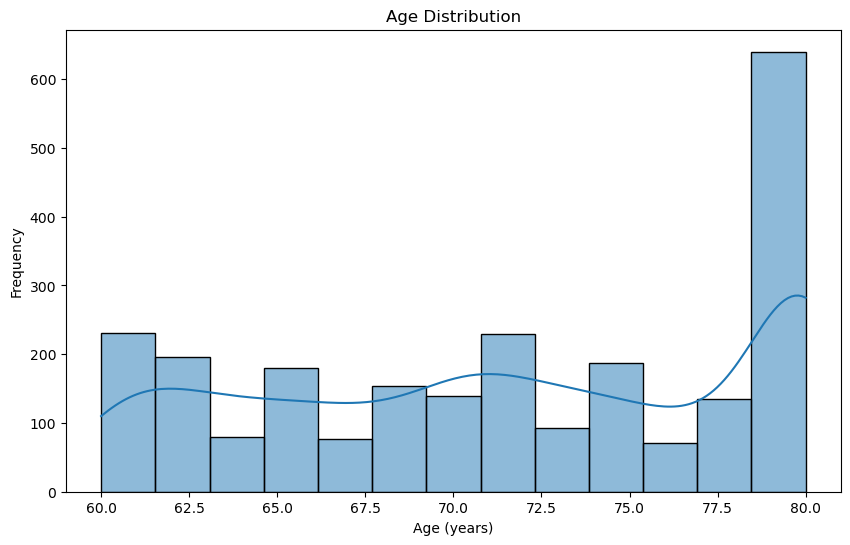

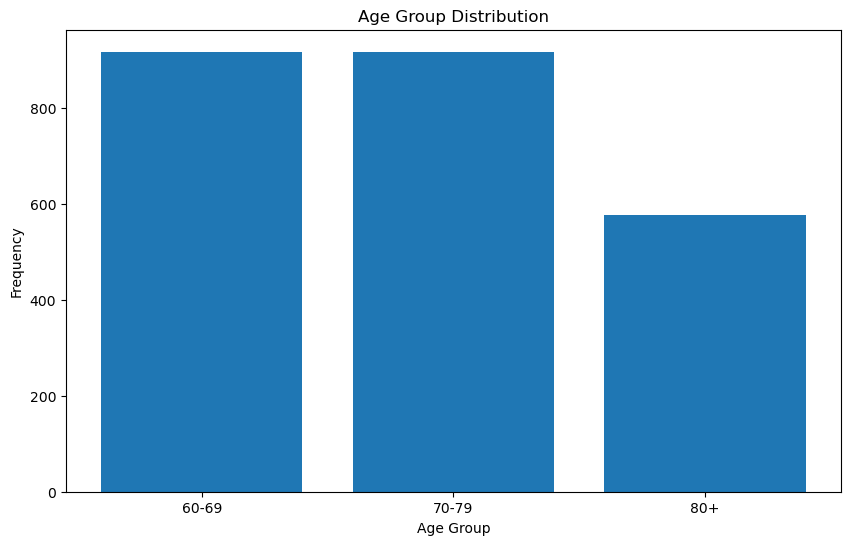

In [7]:
# Check the age distribution in the column 'RIDAGEYR'
plt.figure(figsize=(10, 6))
sns.histplot(data['RIDAGEYR'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.show()

# Group age into 3 categories
data['age_group'] = pd.cut(data['RIDAGEYR'], bins=[60, 70, 80, 100], labels=['60-69', '70-79', '80+'], right = False)
data['age_group'].value_counts()

# Visualize the 3 categories
plt.figure(figsize=(10, 6))
plt.bar(data['age_group'].value_counts().index, data['age_group'].value_counts().values)
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.show()

In [8]:
# Select the columns for right ear measurements

right_ear_columns = ['AUXU500R', 'AUXU1K1R', 'AUXU2KR', 'AUXU3KR', 'AUXU4KR', 'AUXU6KR', 'AUXU8KR']
right_ear_data = data[right_ear_columns]
right_ear_data.columns = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz']

# Select the columns for left ear measurements

left_ear_columns = ['AUXU500L', 'AUXU1K1L', 'AUXU2KL', 'AUXU3KL', 'AUXU4KL', 'AUXU6KL', 'AUXU8KL']
left_ear_data = data[left_ear_columns]
left_ear_data.columns = ['500 Hz', '1 kHz', '2 kHz', '3 kHz', '4 kHz', '6 kHz', '8 kHz']

# Concatenate the right and left ear data

ear_data = pd.concat([right_ear_data, left_ear_data], axis = 0)

# Change the column names to be more descriptive

ear_data

,500 Hz,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz
SEQN,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0
83754,10.0,20.0,10.0,10.0,20.0,25.0,40.0
83755,10.0,10.0,15.0,35.0,30.0,35.0,40.0
83775,55.0,60.0,50.0,50.0,50.0,70.0,75.0
83785,20.0,35.0,30.0,35.0,30.0,35.0,80.0
...,...,...,...,...,...,...,...
124756,10.0,15.0,10.0,25.0,25.0,25.0,40.0
124784,45.0,50.0,50.0,50.0,50.0,45.0,80.0
124799,20.0,40.0,45.0,45.0,60.0,85.0,666.0


In [12]:
# Process missing values
cleaned_ear_data = ear_data.replace([888, 666, '.'], np.nan).dropna()
cleaned_ear_data

,500 Hz,1 kHz,2 kHz,3 kHz,4 kHz,6 kHz,8 kHz
SEQN,,,,,,,
83732,10.0,5.0,5.0,20.0,30.0,25.0,50.0
83754,10.0,20.0,10.0,10.0,20.0,25.0,40.0
83755,10.0,10.0,15.0,35.0,30.0,35.0,40.0
83775,55.0,60.0,50.0,50.0,50.0,70.0,75.0
83785,20.0,35.0,30.0,35.0,30.0,35.0,80.0
...,...,...,...,...,...,...,...
124750,20.0,5.0,15.0,30.0,40.0,40.0,35.0
124756,10.0,15.0,10.0,25.0,25.0,25.0,40.0
124784,45.0,50.0,50.0,50.0,50.0,45.0,80.0


In [16]:
# Standardize the data
scaler = StandardScaler()
scaled_ear_data = scaler.fit_transform(cleaned_ear_data)
scaled_ear_data

array([[-0.63617703, -1.08869548, -1.30627163, ..., -0.55484675,
        -1.07778963, -0.22680907],
       [-0.63617703, -0.0450501 , -1.02179271, ..., -1.03600884,
        -1.07778963, -0.68463627],
       [-0.63617703, -0.74081369, -0.73731378, ..., -0.55484675,
        -0.59892575, -0.68463627],
       ...,
       [ 1.9906407 ,  2.04224067,  1.2540387 , ...,  0.40747743,
        -0.12006188,  1.14667256],
       [ 1.24012135,  0.65071349, -0.73731378, ..., -0.79542779,
         0.358802  ,  0.23101814],
       [-1.01143671, -0.39293189, -0.73731378, ...,  0.40747743,
         0.59823394,  0.91775895]])

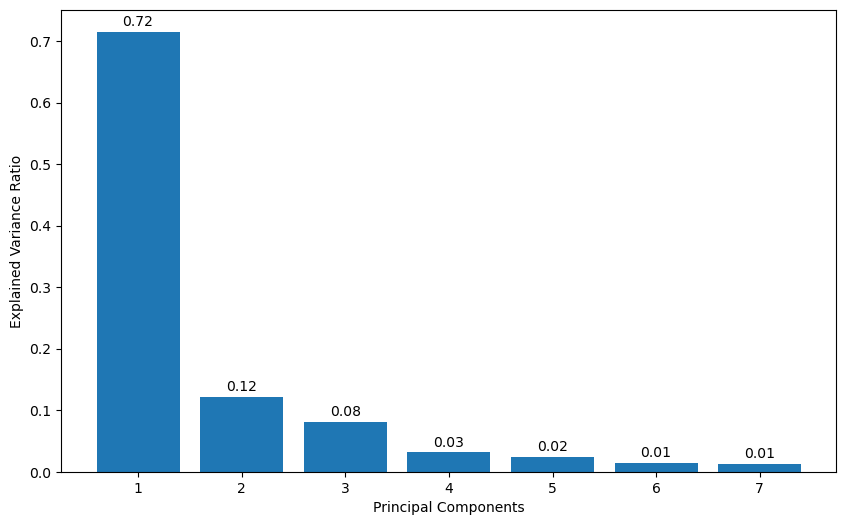

In [17]:
# Initialize a PCA object
pca = PCA(n_components=7)

# Fit the PCA object to the data
pca.fit(cleaned_ear_data)

# Transform the data using the fitted PCA object
pca_data = pca.transform(cleaned_ear_data)

# Visualize the explained variance ratio
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
for i, v in enumerate(pca.explained_variance_ratio_):
    plt.text(i + 1, v + 0.005, f"{v:.2f}", ha='center', va='bottom')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

# Only keep the first 2 principal components
pca_data = pca_data[:, :2]

KMeans with 2 clusters
Silhouette Score: 0.410
Davies Bouldin Score: 0.926
Calinski Harabasz Score: 3878.145
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.302
Davies Bouldin Score: 1.143
Calinski Harabasz Score: 3083.201
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.233
Davies Bouldin Score: 1.341
Calinski Harabasz Score: 2527.988
--------------------------------------------------


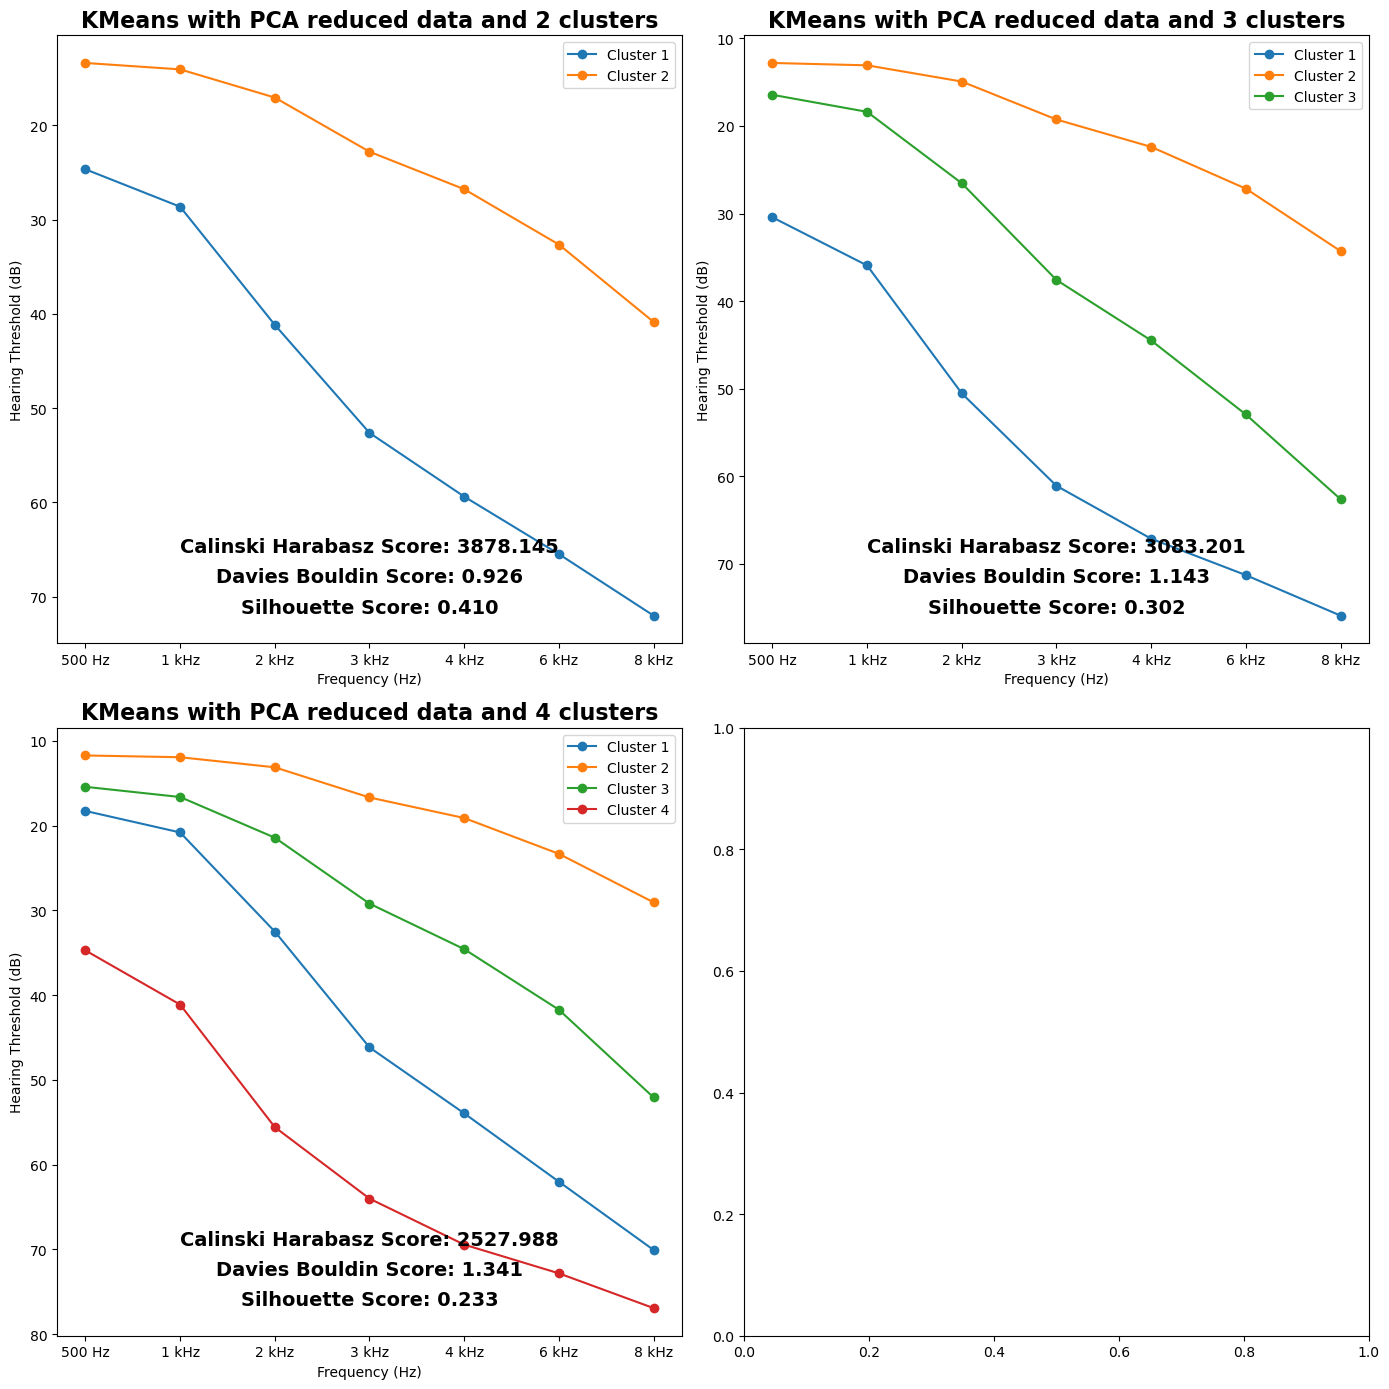

In [21]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(pca_data)

    # Extract the centroids
    ear_df = cleaned_ear_data.copy()
    ear_df['label'] = kmeans.labels_
    centroids = ear_df.groupby('label').mean()
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with PCA reduced data and {i} clusters', fontsize=16, fontweight='bold')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

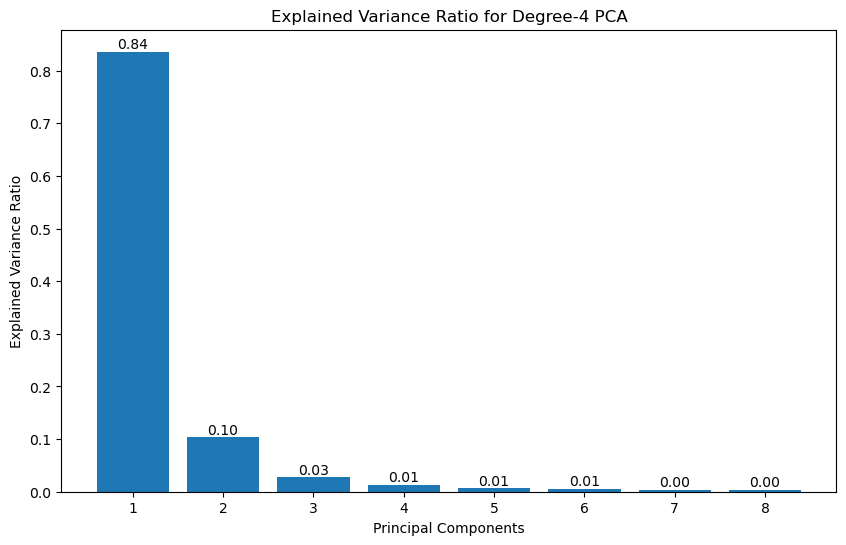

In [22]:
# Initialize a 4-degree Kernel PCA object
poly_pca = KernelPCA(n_components=8, kernel='poly', degree=4)

# Fit the a 3-degree Kernel PCA object to the data
poly_pca_data = poly_pca.fit_transform(cleaned_ear_data)

# Visualize the explained variance ratio
explained_variance = np.var(poly_pca_data, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)

plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
for i, v in enumerate(explained_variance_ratio):
    plt.text(i + 1, v, f"{v:.2f}", ha='center', va='bottom')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio for Degree-4 PCA')
plt.show()

poly_pca_data = poly_pca_data[:, :2]

KMeans with 2 clusters
Silhouette Score: 0.364
Davies Bouldin Score: 0.894
Calinski Harabasz Score: 1780.914
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.360
Davies Bouldin Score: 0.780
Calinski Harabasz Score: 1034.806
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.324
Davies Bouldin Score: 0.976
Calinski Harabasz Score: 959.637
--------------------------------------------------


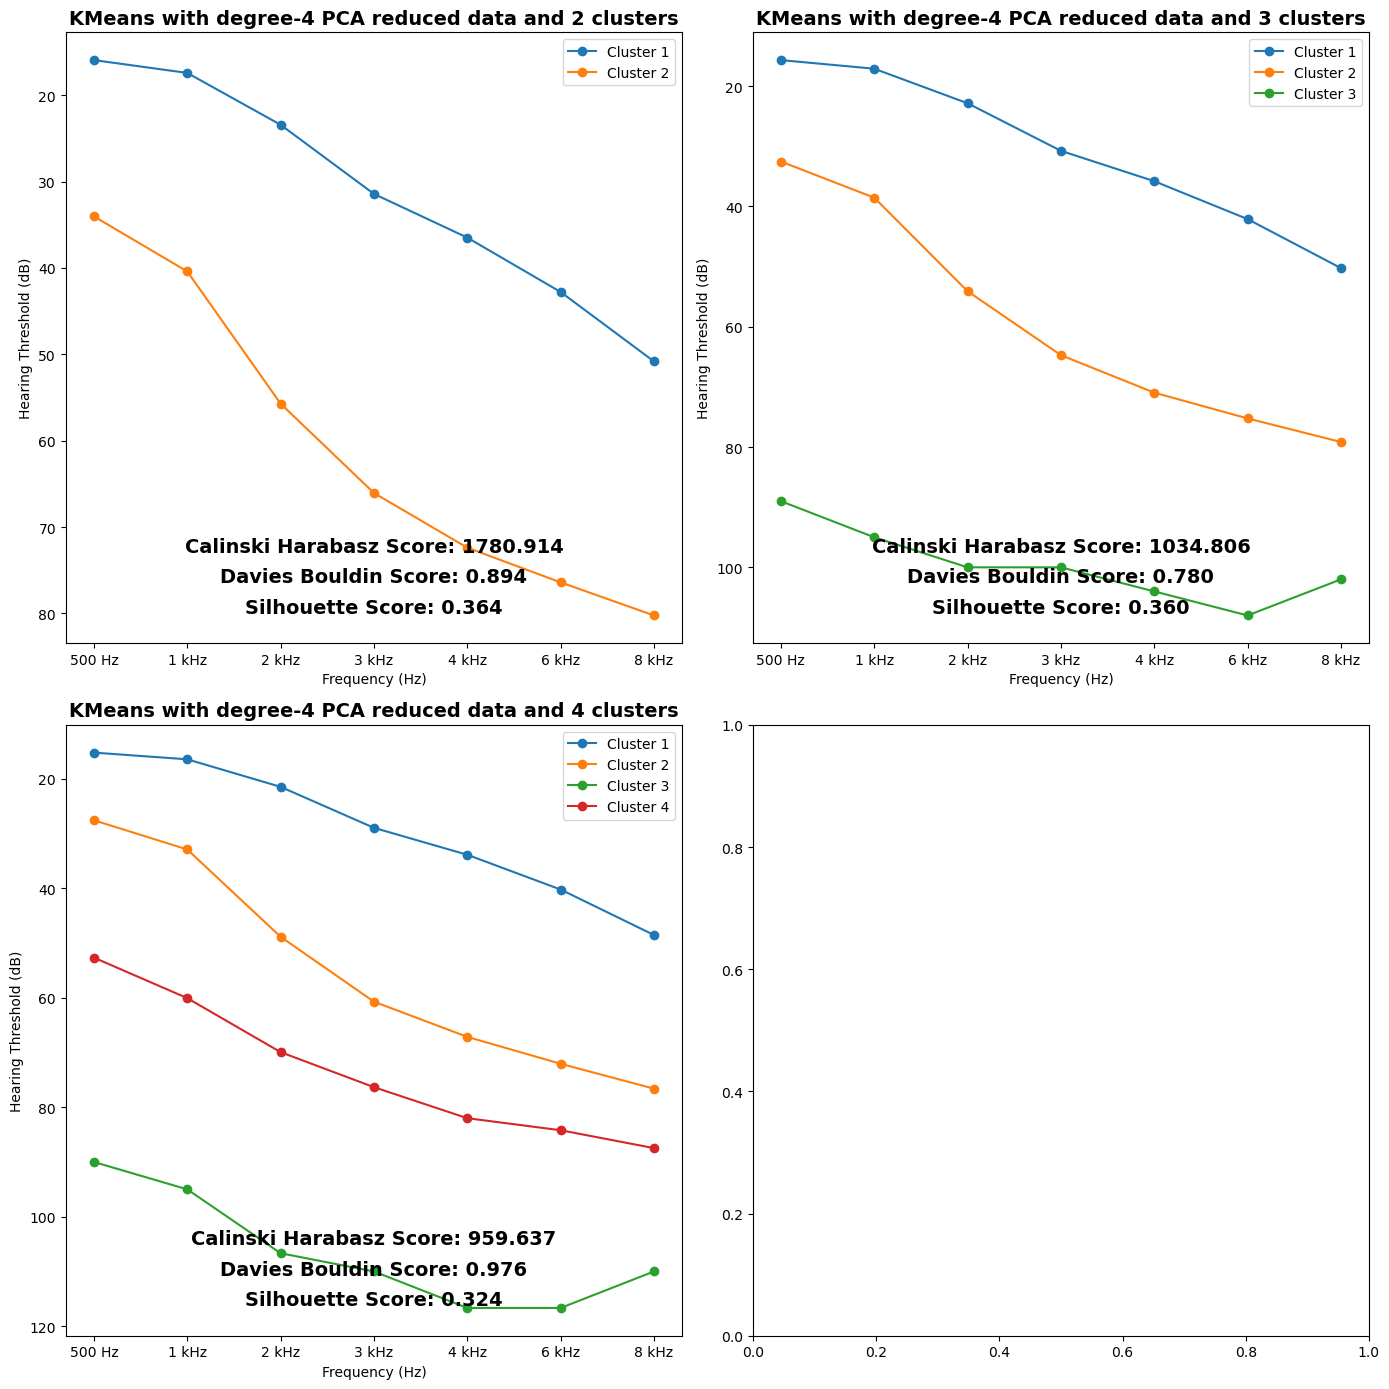

In [23]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(poly_pca_data)

    # Extract the centroids
    ear_df = cleaned_ear_data.copy()
    ear_df['label'] = kmeans.labels_
    centroids = ear_df.groupby('label').mean()
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with degree-4 PCA reduced data and {i} clusters', fontsize=14, fontweight='bold')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

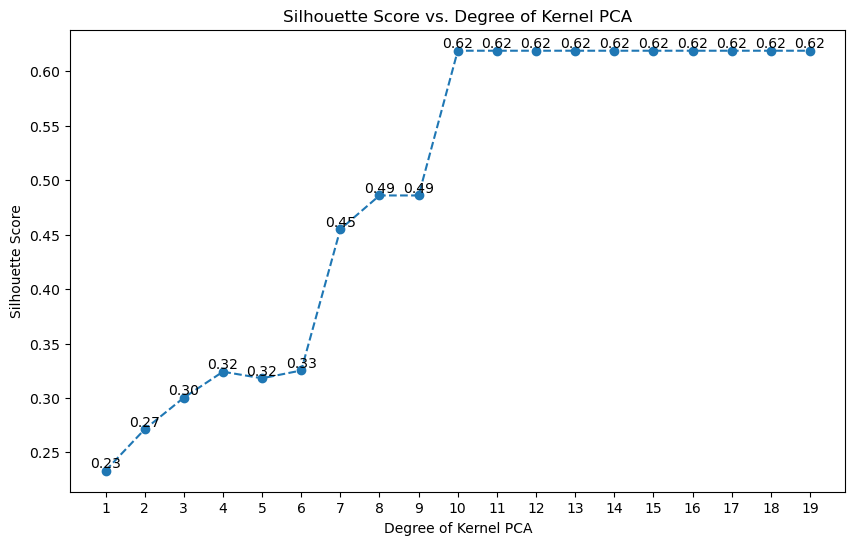

In [24]:
# Test the Silhouette score with different degrees of Kernel PCA (k = 4)
silhouette_scores = []

for i in range(1, 20):

    poly_pca = KernelPCA(n_components=8, kernel='poly', degree=i)
    poly_pca_data = poly_pca.fit_transform(cleaned_ear_data)
    poly_pca_data = poly_pca_data[:, :2]

    kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
    kmeans.fit(poly_pca_data)

    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    silhouette_scores.append(silhouette)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), silhouette_scores, marker='o', linestyle='--')
for i, v in enumerate(silhouette_scores):
    plt.text(i + 1, v, f"{v:.2f}", ha='center', va='bottom')
plt.title('Silhouette Score vs. Degree of Kernel PCA')
plt.xlabel('Degree of Kernel PCA')
plt.ylabel('Silhouette Score')
plt.xticks(range(1, 20))  # Ensure x-axis is integers
plt.show()

Group sizes for Degree-4 Kernel PCA:
label
0    2969
1     760
3      75
2       3
Name: count, dtype: int64
--------------------------------------------------
Group sizes for Degree-7 Kernel PCA:
label
0    3775
2      29
3       2
1       1
Name: count, dtype: int64
--------------------------------------------------
Group sizes for Degree-9 Kernel PCA:
label
0    3787
3      17
2       2
1       1
Name: count, dtype: int64
--------------------------------------------------
Group sizes for Degree-10 Kernel PCA:
label
0    3804
2       1
3       1
1       1
Name: count, dtype: int64
--------------------------------------------------


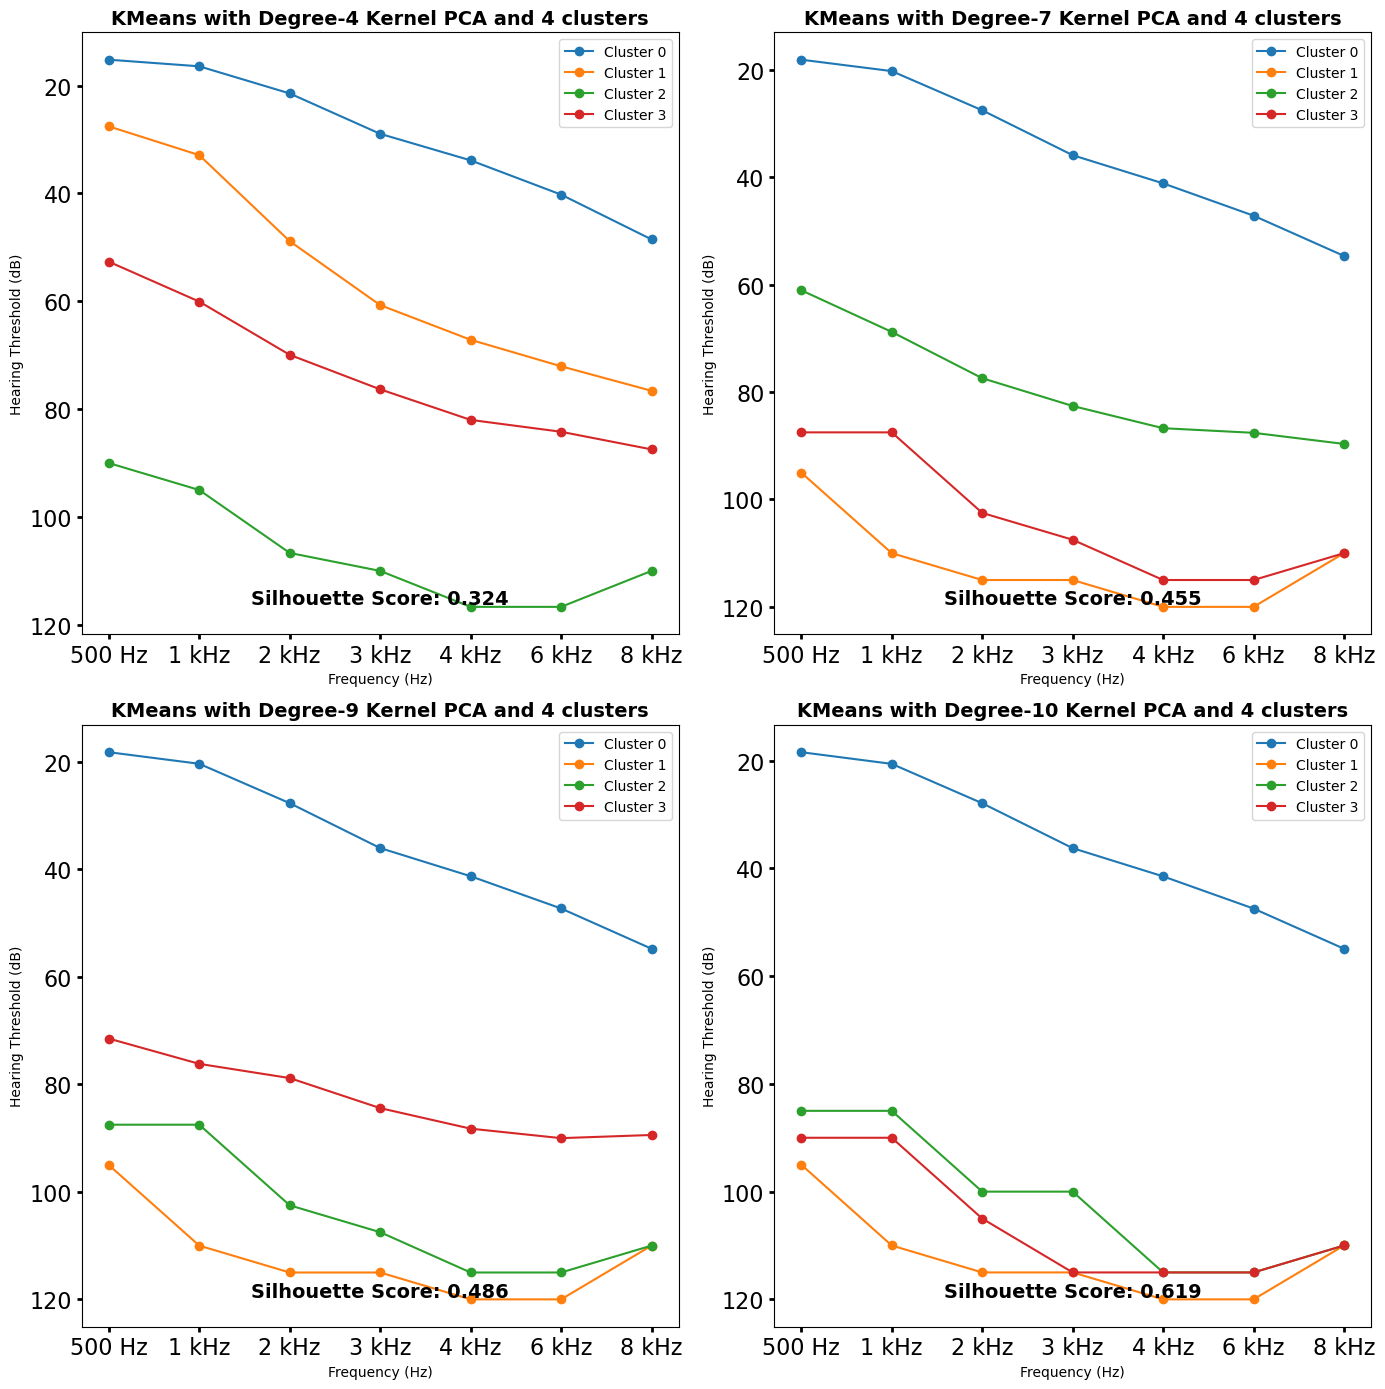

In [27]:
# Initialize a 2x2 grid for plotting
fig, ax = plt.subplots(2, 2, figsize=(14, 14))

# Degrees to be tested
degrees = [4, 7, 9, 10]

for idx, degree in enumerate(degrees):
    # Initialize a Kernel PCA object with the specified degree
    poly_pca = KernelPCA(n_components=8, kernel='poly', degree=degree)
    
    # Fit and transform the data
    poly_pca_data = poly_pca.fit_transform(cleaned_ear_data)
    poly_pca_data = poly_pca_data[:, :2]
    
    # Initialize and fit the KMeans object
    kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
    kmeans.fit(poly_pca_data)
    
    # Extract the centroids
    ear_df = cleaned_ear_data.copy()
    ear_df['label'] = kmeans.labels_
    centroids = ear_df.groupby('label').mean()
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)
    
    # Plot the line plot
    row = idx // 2 # take the floor division
    col = idx % 2 # take the modulo
    for cluster_id in range(4):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id}'
        )
    
    # Annotate the plot
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}',
                            xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].set_title(f'KMeans with Degree-{degree} Kernel PCA and 4 clusters', fontsize=14, fontweight='bold')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Bold the x and y axes ticks
    ax[row, col].tick_params(axis='x', labelsize=16, width=2)
    ax[row, col].tick_params(axis='y', labelsize=16, width=2)

    # Print out the group sizes
    print(f'Group sizes for Degree-{degree} Kernel PCA:')
    print(ear_df['label'].value_counts())
    print('-' * 50)

plt.tight_layout()
plt.show()

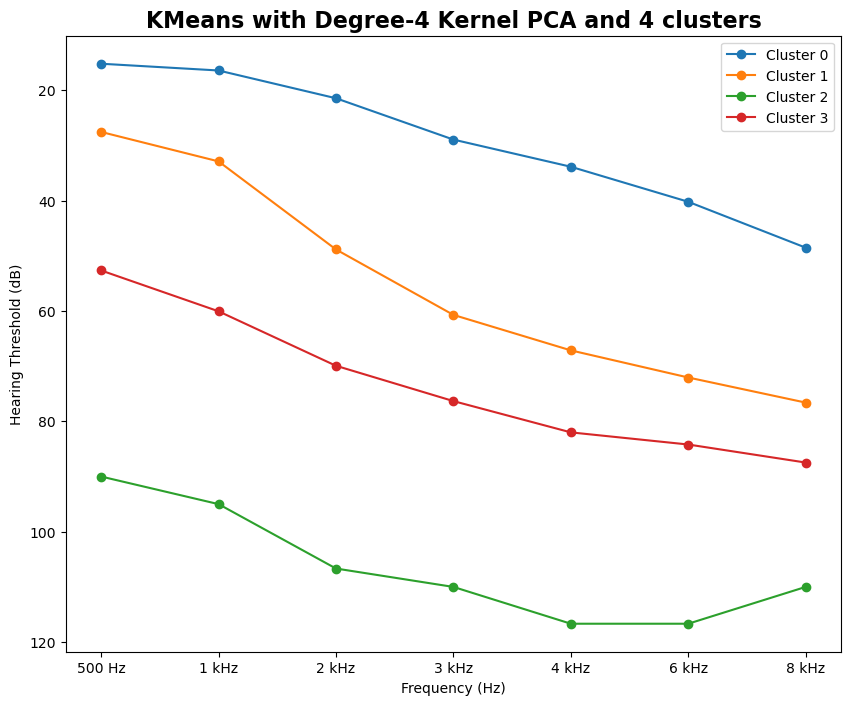

Group sizes for Degree-4 Kernel PCA:
label
0    2969
1     760
3      75
2       3
Name: count, dtype: int64
--------------------------------------------------


In [29]:
# Export the degree-4 Kernel PCA data

# Initialize a Kernel PCA object with the specified degree
poly_pca = KernelPCA(n_components=8, kernel='poly', degree=4)

# Fit and transform the data
poly_pca_data = poly_pca.fit_transform(cleaned_ear_data)
poly_pca_data = poly_pca_data[:, :2]

# Initialize and fit the KMeans object
kmeans = KMeans(n_clusters=4, random_state=42, n_init='auto')
kmeans.fit(poly_pca_data)

# Extract the centroids
ear_df = cleaned_ear_data.copy()
ear_df['label'] = kmeans.labels_
centroids = ear_df.groupby('label').mean()
centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

# Plot the line plot
plt.figure(figsize=(10, 8))
for cluster_id in range(4):
    plt.plot(
        centroids_df.columns, 
        centroids_df.iloc[cluster_id], 
        marker='o', 
        label=f'Cluster {cluster_id}'
    )
plt.title(f'KMeans with Degree-4 Kernel PCA and 4 clusters', fontsize=16, fontweight='bold')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Hearing Threshold (dB)')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

print(f'Group sizes for Degree-4 Kernel PCA:')
print(ear_df['label'].value_counts())
print('-' * 50)

# Dimensionality Reduction with t-SNE

In [30]:
# Initialize a t-SNE object
tsne = TSNE(n_components=2, perplexity=30, n_jobs=-1, random_state=42)

# Fit the t-SNE object to the data
tsne_data = tsne.fit_transform(cleaned_ear_data)

KMeans with 2 clusters
Silhouette Score: 0.399
Davies Bouldin Score: 0.936
Calinski Harabasz Score: 3745.532
--------------------------------------------------
KMeans with 3 clusters
Silhouette Score: 0.271
Davies Bouldin Score: 1.183
Calinski Harabasz Score: 2838.682
--------------------------------------------------
KMeans with 4 clusters
Silhouette Score: 0.191
Davies Bouldin Score: 1.498
Calinski Harabasz Score: 2243.823
--------------------------------------------------


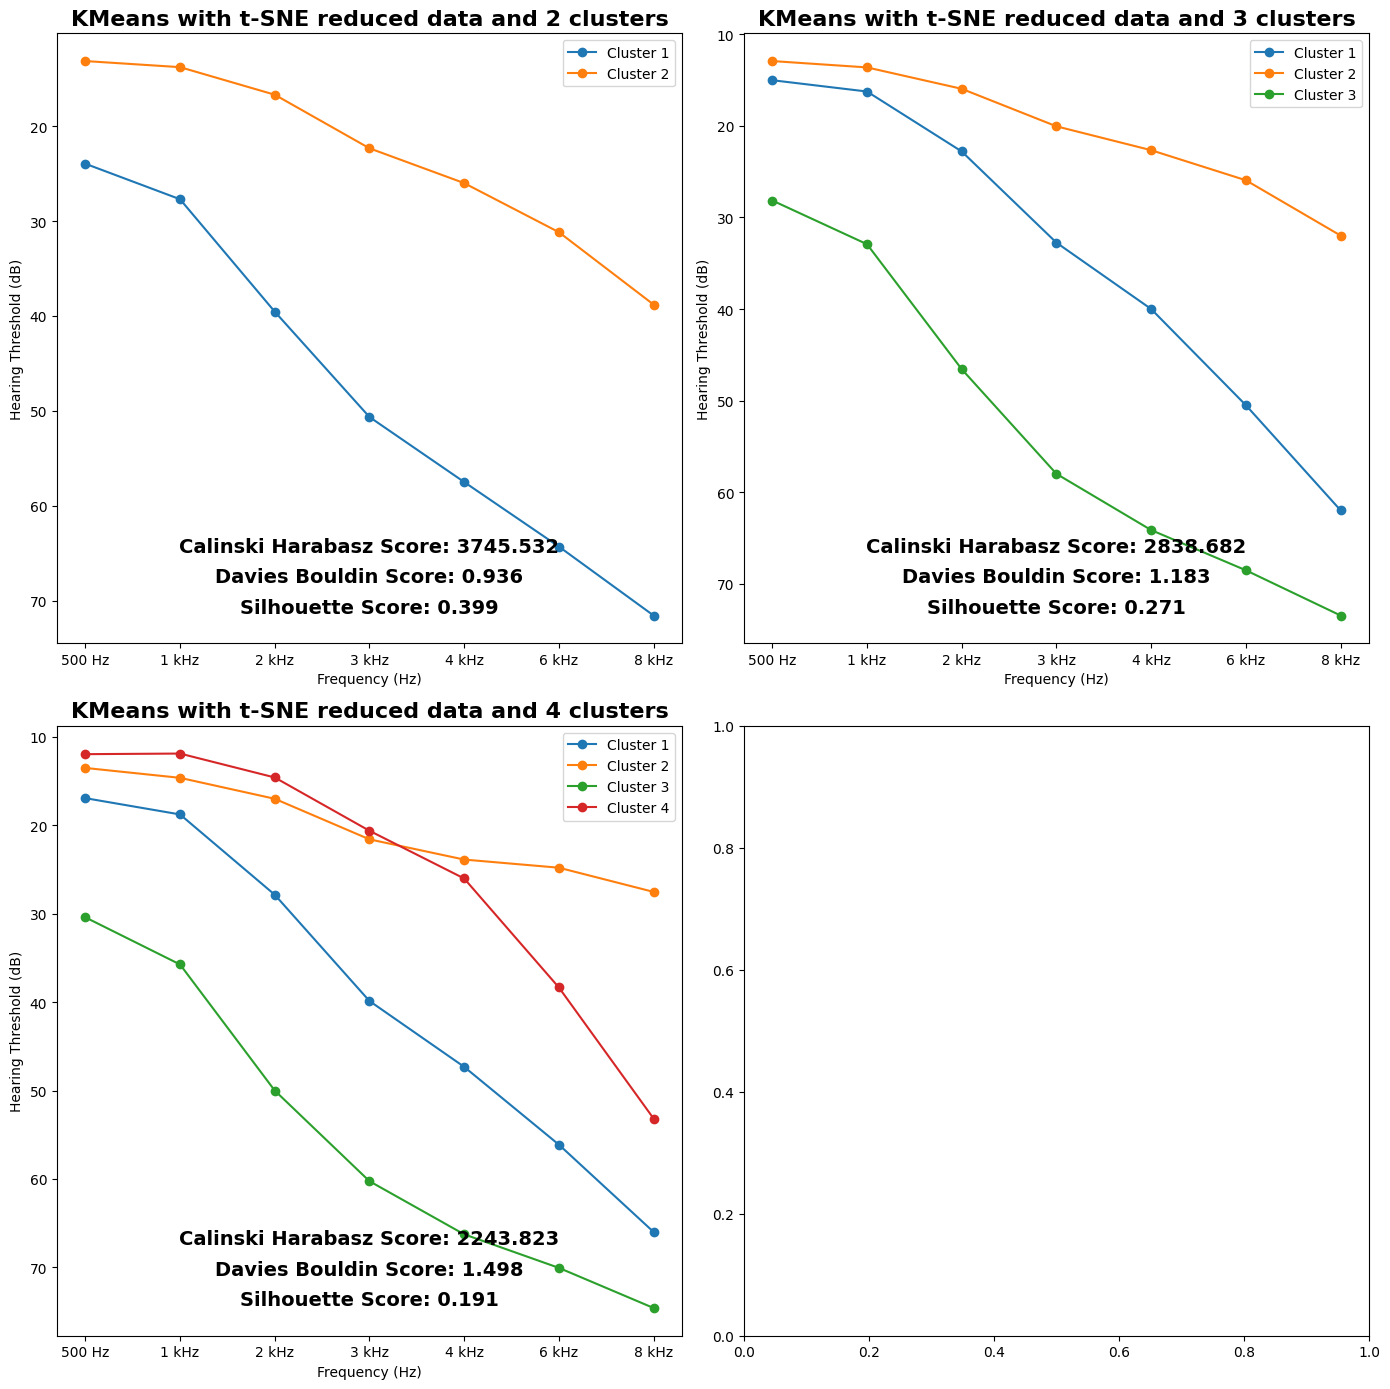

In [109]:
# Fit the K-Means algorithm with n clusters = 2, 3, 4

fig, ax = plt.subplots(2, 2, figsize=(14, 14))

for i in range(2, 5):
    # Initialize the KMeans object
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(tsne_data)

    # Extract the centroids
    ear_df = cleaned_ear_data.copy()
    ear_df['label'] = kmeans.labels_
    centroids = ear_df.groupby('label').mean()
    centroids_df = pd.DataFrame(centroids, columns=cleaned_ear_data.columns)

    # Plot the line plot
    row = (i - 2) // 2
    col = (i - 2) % 2
    for cluster_id in range(i):
        ax[row, col].plot(
            centroids_df.columns, 
            centroids_df.iloc[cluster_id], 
            marker='o', 
            label=f'Cluster {cluster_id + 1}'
        )
    ax[row, col].set_title(f'KMeans with t-SNE reduced data and {i} clusters', fontsize=16, fontweight='bold')
    ax[row, col].set_xlabel('Frequency (Hz)')
    ax[row, col].set_ylabel('Hearing Threshold (dB)')
    ax[row, col].invert_yaxis()
    ax[row, col].legend()

    # Annotate the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
    davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
    calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

    ax[row, col].annotate(f'Silhouette Score: {silhouette:.3f}', 
                          xy=(0.5, 0.05), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].annotate(f'Davies Bouldin Score: {davies_bouldin:.3f}',
                            xy=(0.5, 0.10), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    ax[row, col].annotate(f'Calinski Harabasz Score: {calinski_harabasz:.3f}',
                            xy=(0.5, 0.15), xycoords='axes fraction', ha='center', fontsize=14, fontweight='bold')
    
    # Print out the Silhouette, Davies Bouldin, and Calinski Harabasz scores
    print(f'KMeans with {i} clusters')
    print(f'Silhouette Score: {silhouette:.3f}')
    print(f'Davies Bouldin Score: {davies_bouldin:.3f}')
    print(f'Calinski Harabasz Score: {calinski_harabasz:.3f}')
    print('-' * 50)

plt.tight_layout()
plt.show()

# K-Means with both standardization and various dimensionality reduction techniques

In [110]:
# Standardize the data
standard_scaler = StandardScaler()
standard_scaled_data = standard_scaler.fit_transform(cleaned_ear_data)

# Min-max scaling
minmax_scaler = MinMaxScaler()
minmax_scaled_data = minmax_scaler.fit_transform(cleaned_ear_data)

# Robust scaling
## Note: Robust scaling is computed as (X - median) / IQR
robust_scaler = RobustScaler()
robust_scaled_data = robust_scaler.fit_transform(cleaned_ear_data)

# Quantile transformation
quantile_transformer = QuantileTransformer(output_distribution = 'normal')
quantile_transformed_data = quantile_transformer.fit_transform(cleaned_ear_data)

In [111]:
dim_reduce_methods = {
    "z-score": standard_scaled_data,
    "min-max scaling": minmax_scaled_data,
    "robust scaling": robust_scaled_data,
    "quantile transformation": quantile_transformed_data,
    'PCA': pca_data,
    'Kernel PCA': poly_pca_data,
    't-SNE': tsne_data
}

# Initialize a dictionary to store the results
results = []

for method, data in dim_reduce_methods.items():
    for n_clusters in range(2, 5):
        # Initialize and fit the KMeans object
        kmeans = KMeans(n_clusters = n_clusters, random_state = 42, n_init = 'auto')
        kmeans.fit(data)

        # Calculate clustering scores
        silhouette = silhouette_score(cleaned_ear_data, kmeans.labels_)
        davies_bouldin = davies_bouldin_score(cleaned_ear_data, kmeans.labels_)
        calinski_harabasz = calinski_harabasz_score(cleaned_ear_data, kmeans.labels_)

        # Append the results to the list
        results.append({
            "Method": method,
            "Number of Clusters": n_clusters,
            "Silhouette Score": round(silhouette, 3),
            "Davies-Bouldin Score": round(davies_bouldin, 3),
            "Calinski-Harabasz Score": round(calinski_harabasz, 3)
        })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

results_df

,Method,Number of Clusters,Silhouette Score,Davies-Bouldin Score,Calinski-Harabasz Score
0,z-score,2,0.405,0.934,3775.086
1,z-score,3,0.310,1.175,2911.064
2,z-score,4,0.250,1.327,2448.683
3,min-max scaling,2,0.409,0.927,3873.862
4,min-max scaling,3,0.301,1.134,3073.120
5,min-max scaling,4,0.237,1.321,2526.085
6,robust scaling,2,0.392,0.959,3530.049
7,robust scaling,3,0.309,1.238,2664.217
8,robust scaling,4,0.242,1.373,2369.904
9,quantile transformation,2,0.393,0.952,3643.617
